# AES V2 Side-channel Analysis

#### Recover the Key

<img src='images/DoIt.png' style='width: 100px'>

# ONE SOLUTION

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
    
plt.rcParams["figure.figsize"] = [20, 5]

---
<img src='images/DoIt.png' style='width: 100px'>

## Import the traces needed for the analysis

<img src='images/DoIt.png' style='width: 100px'>

#### Load the trace 'AESV2_12Ktraces_set.ets'
from SideSCA-Traces-Public: git clone https://github.com/BeneoLix/SideSCA-Traces-Public.git

In [2]:
import estraces

In [3]:
ths = estraces.read_ths_from_ets_file("../SideSCA-Traces-Public/AESV2_12Ktraces_set.ets") 

---
<img src='images/DoIt.png' style='width: 100px'>

#### Print the ths information, the ths len


In [4]:
print(ths)

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file ../SideSCA-Traces-Public/AESV2_12Ktraces_set.ets with 12000 traces.
ciphertext.......: uint8
key..............: uint8
plaintext........: uint8



---
<img src='images/DoIt.png' style='width: 100px'>

## Plot and Observe  the traces


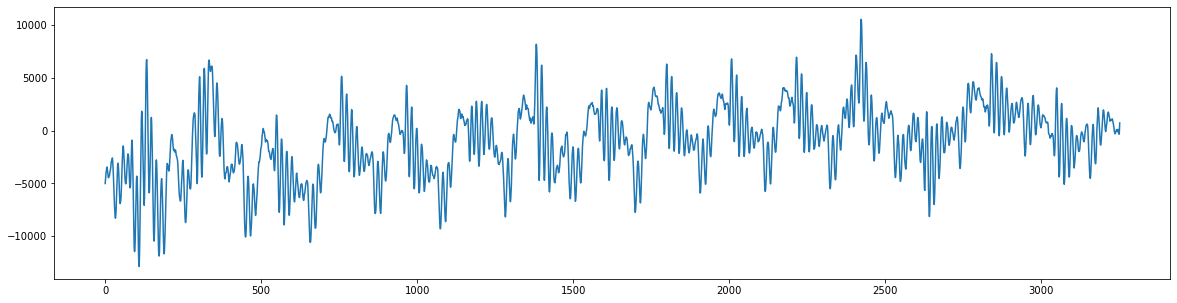

In [5]:
plt.plot(ths[0].samples.T)
plt.show()

-------------
<img src='images/DoIt.png' style='width: 100px'>

### Now perform the right attack to recover the key

------

In [7]:
import scared

In [10]:
# Create a container for your ths
container = scared.Container(ths)

----
## Attack the first round 

In [18]:
attack_cpa_first_SBout = scared.CPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.HammingWeight(),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//10    
    )

In [19]:
attack_cpa_first_SBout.run(container)

In [20]:
found_key = attack_cpa_first_SBout.scores.argmax(0).squeeze()

In [24]:
correct_key = ths[0].key

In [26]:
vhex = np.vectorize(hex)
print("the first round key found is: ", vhex(found_key))
print("the correct first round key is", vhex(correct_key))

the first round key found is:  ['0xd4' '0xea' '0xd7' '0xc' '0x41' '0x9c' '0x94' '0x64' '0x3b' '0x39'
 '0xa3' '0xbf' '0xee' '0xfc' '0xde' '0x6a']
the correct first round key is ['0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x3' '0x24' '0x3f' '0x6a'
 '0x88' '0x85' '0xa3' '0x8' '0xd3']


In [27]:
found_key - correct_key

array([ 212,  234,  215,   12,   65,  156,  148,   97,   23,   -6,   57,
         55,  105,   89,  214, -105])

## The key is not recovered !

#### Plot Results

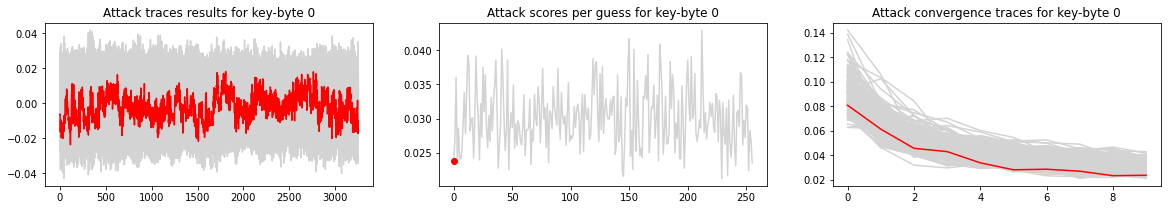

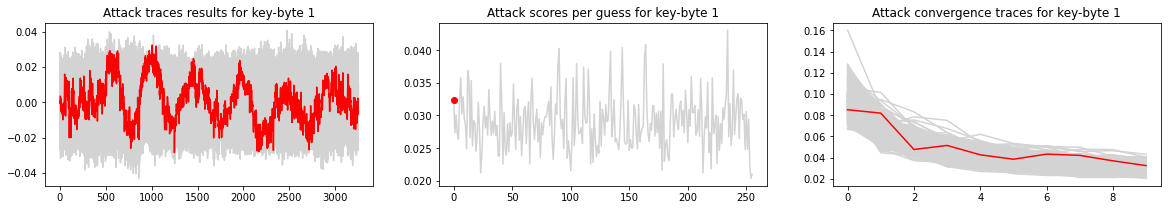

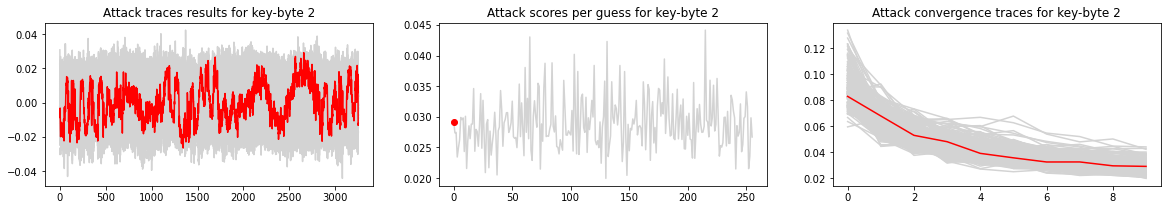

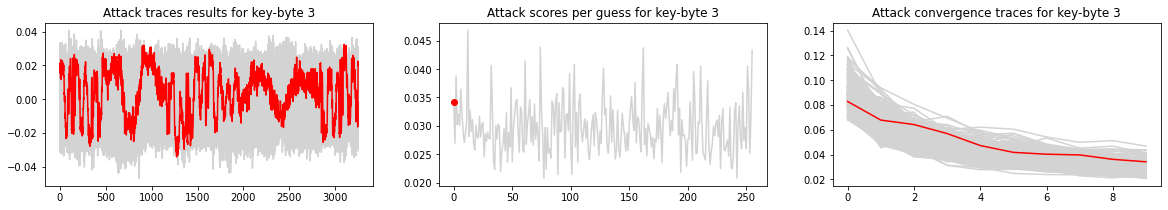

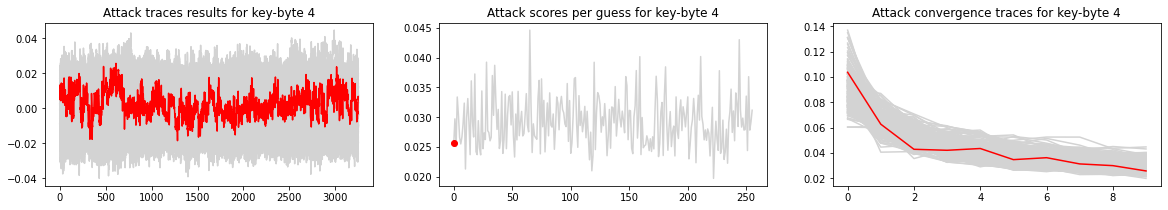

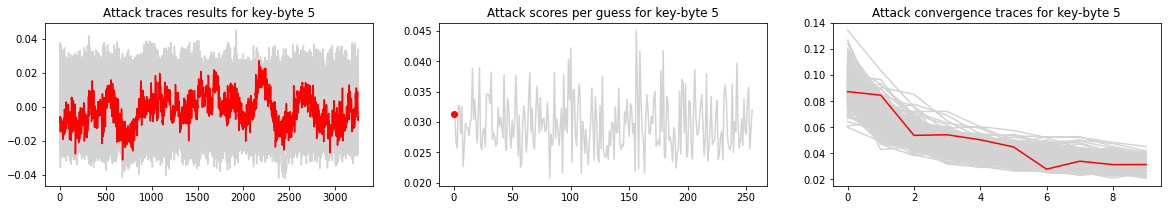

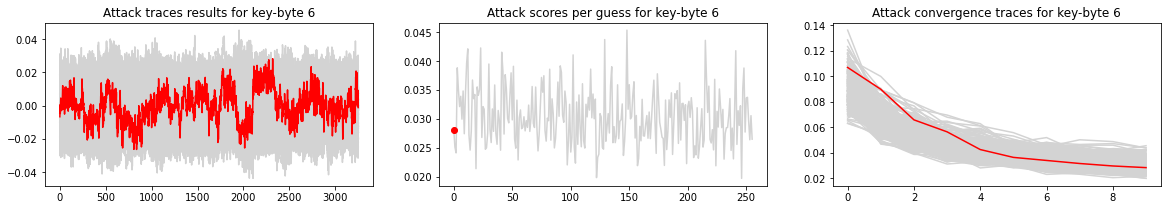

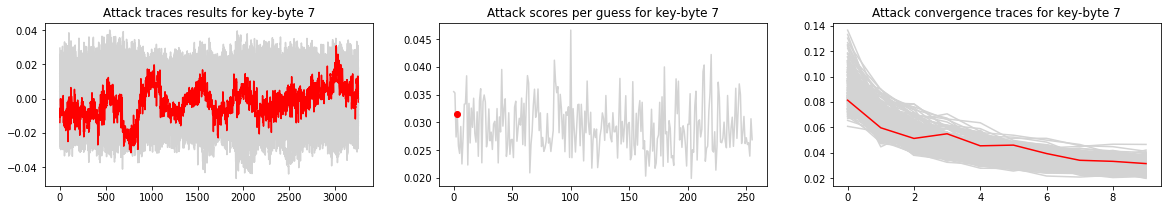

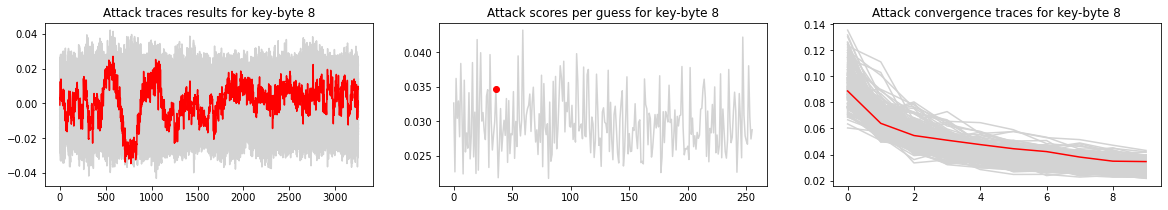

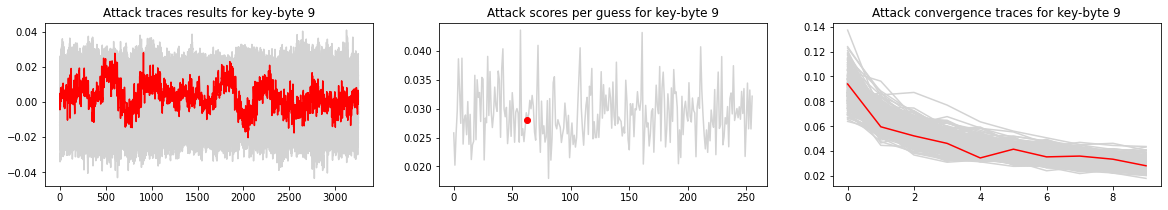

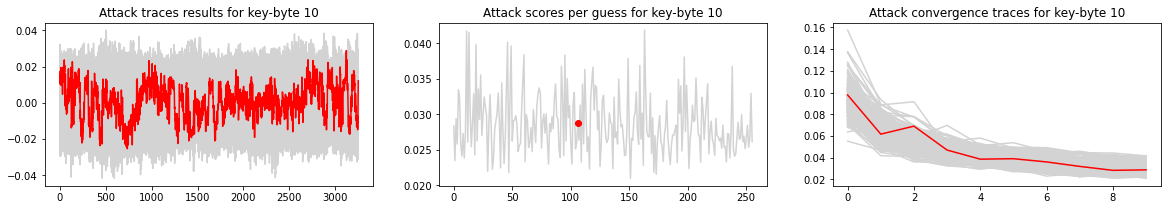

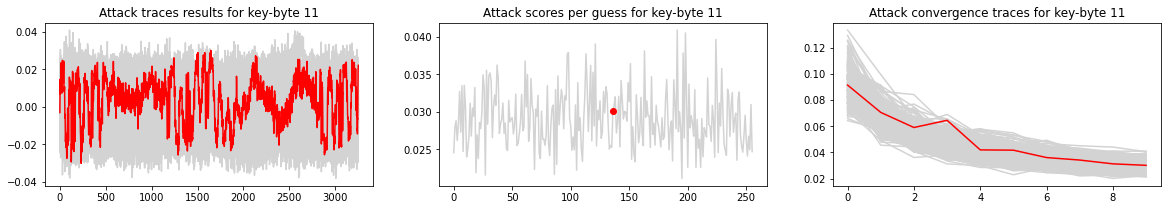

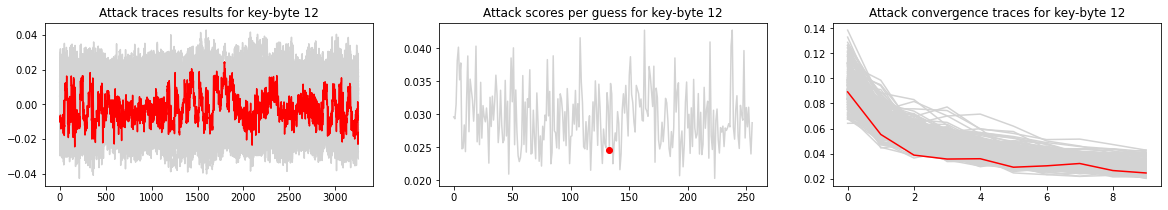

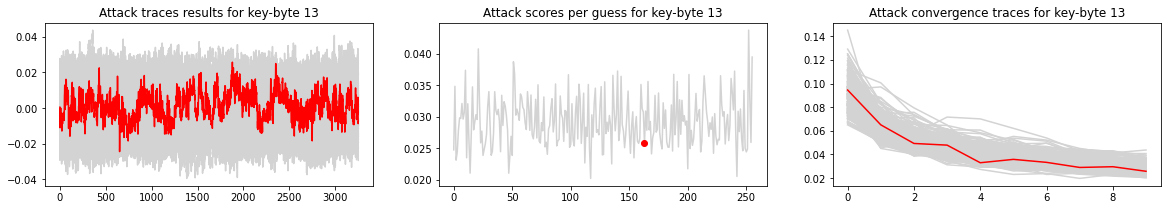

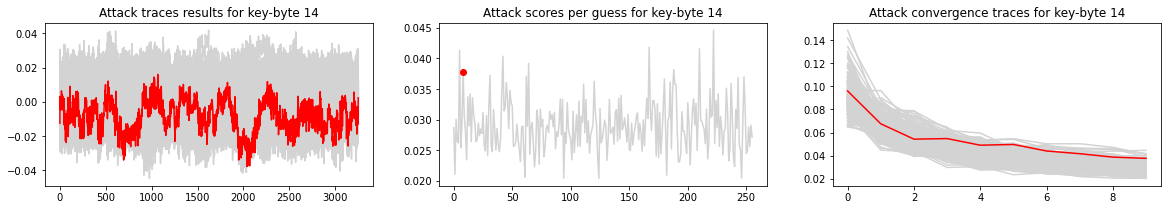

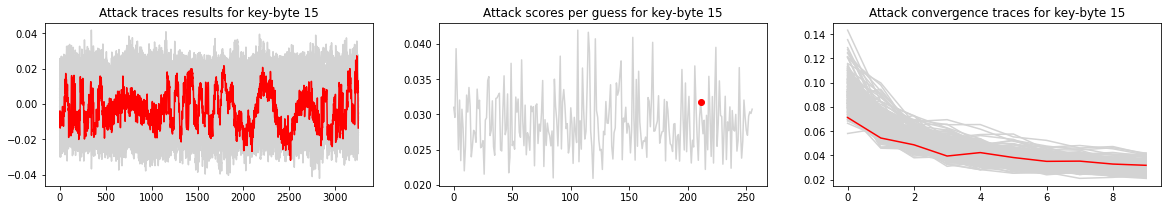

In [28]:
for key_byte in range(16):
    plt.rcParams['figure.figsize']=(20,3)
    
    plt.subplot(1,3,1)
    plt.title('Attack traces results for key-byte '+str(key_byte))
    for guess in range(256):
        plt.plot(attack_cpa_first_SBout.results[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_cpa_first_SBout.results[correct_key[key_byte],key_byte,:], color='red')

    plt.subplot(1,3,2)
    plt.title('Attack scores per guess for key-byte '+str(key_byte))
    plt.plot(attack_cpa_first_SBout.scores[:,key_byte], color='Lightgrey')
    plt.plot(correct_key[key_byte], attack_cpa_first_SBout.scores[correct_key[key_byte], key_byte], "o", color = 'red')

    
    plt.subplot(1,3,3)
    plt.title('Attack convergence traces for key-byte '+str(key_byte))
    for guess in range(256):
        plt.plot(attack_cpa_first_SBout.convergence_traces[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_cpa_first_SBout.convergence_traces[correct_key[key_byte],key_byte,:], color='red')

    plt.show()

----
## Attack the last round in delta with CPA

In [29]:
attack_cpa_delta_last = scared.CPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.DeltaRLastRounds(),
        model=scared.HammingWeight(),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//10    
    )

In [30]:
attack_cpa_delta_last.run(container)

In [31]:
found_key = attack_cpa_delta_last.scores.argmax(0).squeeze()

In [32]:
vhex = np.vectorize(hex)
print("the last subkey round found is: ", vhex(found_key))

the last subkey round found is:  ['0xd6' '0x9f' '0xb1' '0x88' '0x40' '0x7e' '0x2b' '0x3f' '0x2d' '0x5a'
 '0x24' '0x5f' '0x50' '0xfe' '0xbe' '0xe1']


### Ici nous attaquons la dernière ronde de l'AES, donc la clef attendue est la dernière sous clef du key schedule de l'AES 128 et non pas la clef maitre de l'AES.

Calculons donc cette dernière sous clef pour la comparer avec la clef attendue.

In [37]:
correct_key = scared.aes.key_schedule(ths[0].key)[-1]
print("the correct last subkey round is: ", vhex(right_key))

the correct last subkey round is:  ['0x53' '0x9f' '0xb1' '0x88' '0x40' '0x7e' '0x2b' '0x3f' '0x2d' '0x5a'
 '0x24' '0x5f' '0x50' '0xfe' '0xbe' '0xe1']


In [38]:
found_key - correct_key

array([131,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0])

### Nous avons donc retrouvé 15 bytes de la clef, il nous en manque un.

#### Plot Results

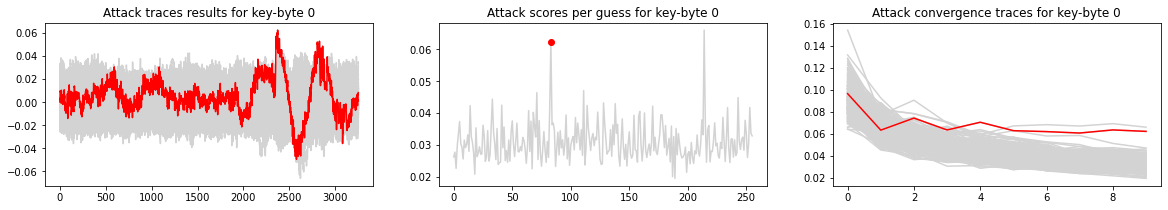

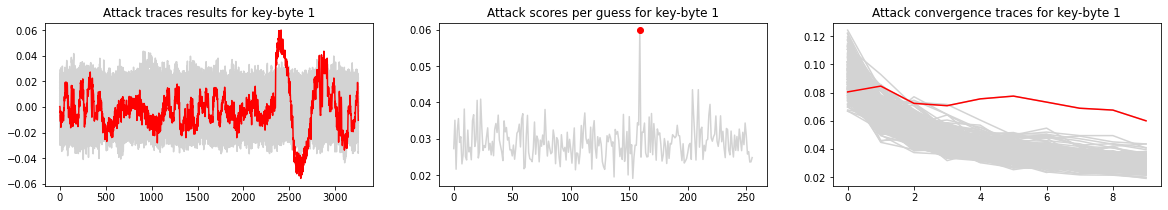

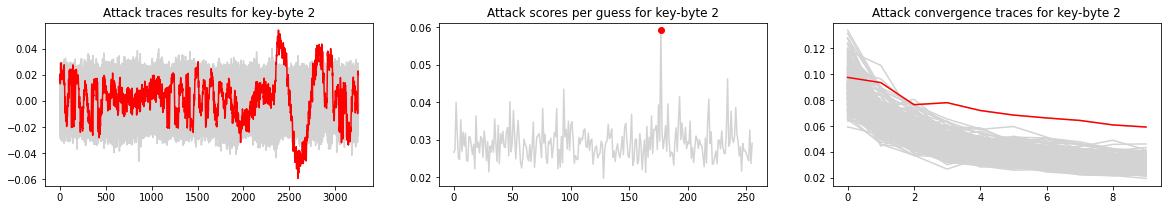

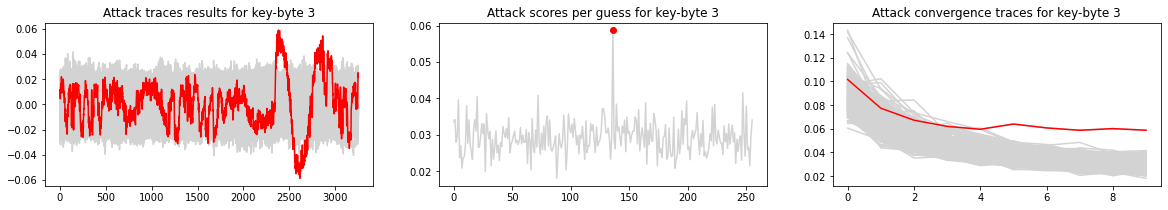

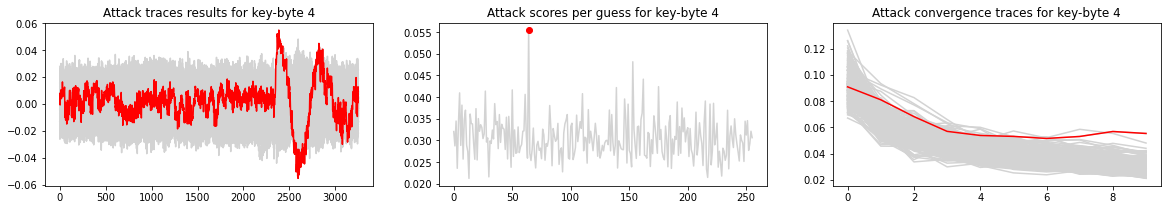

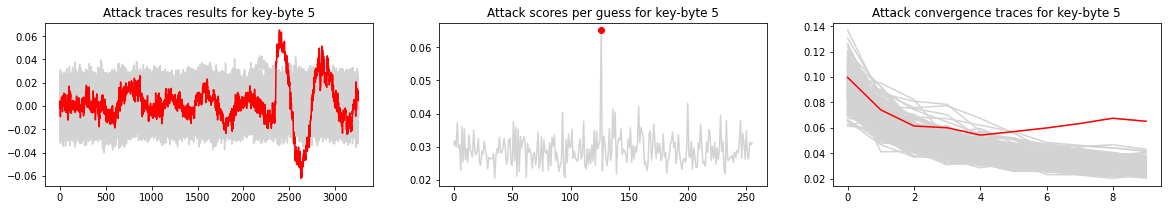

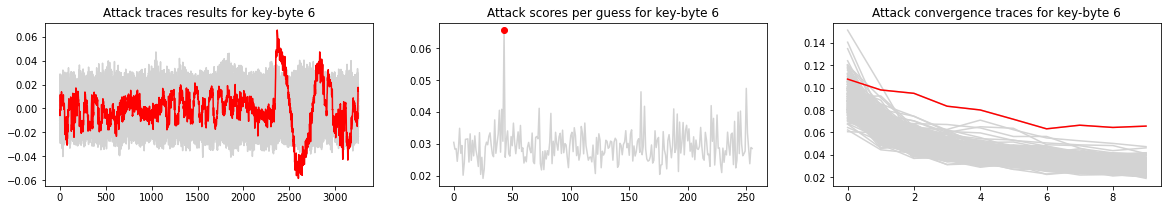

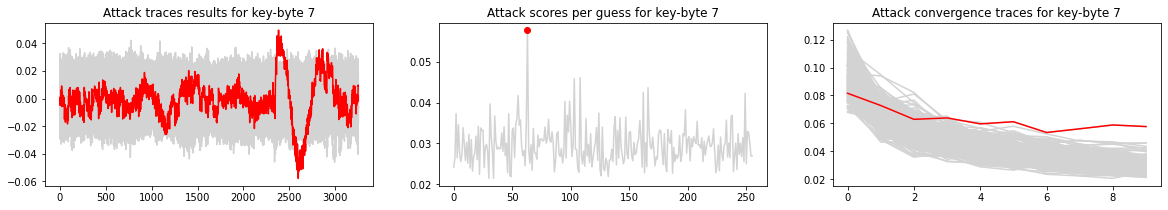

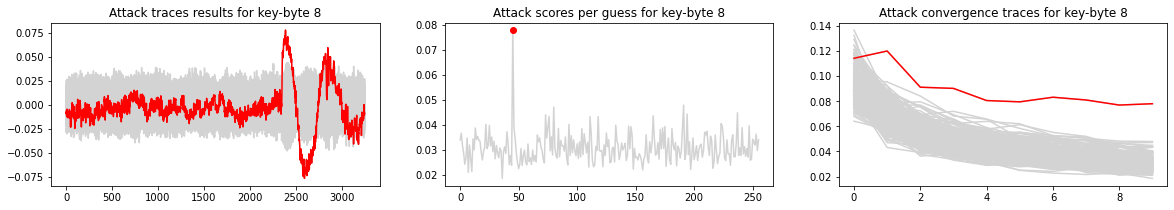

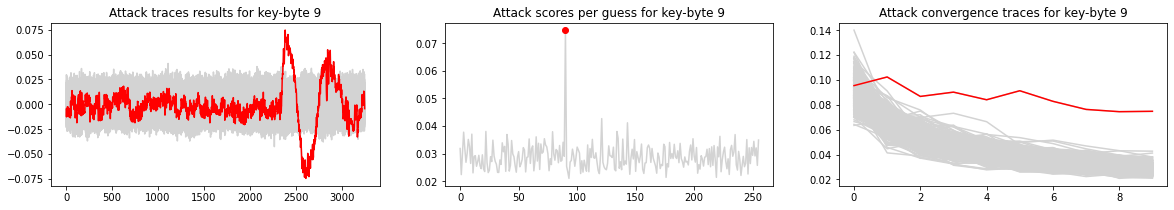

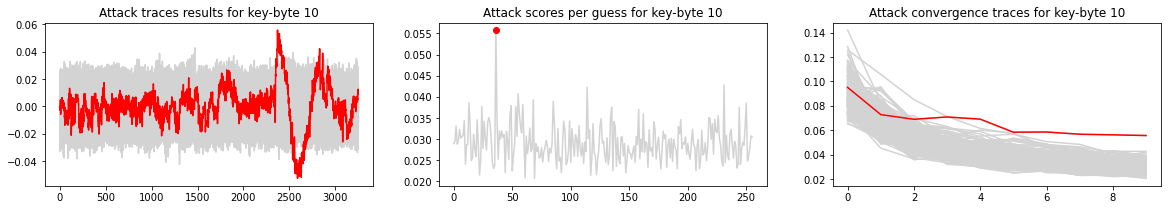

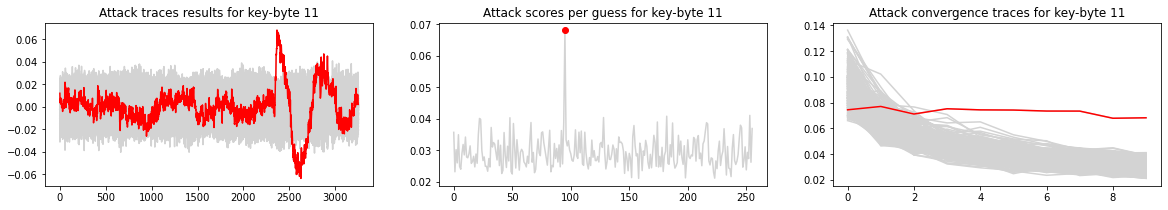

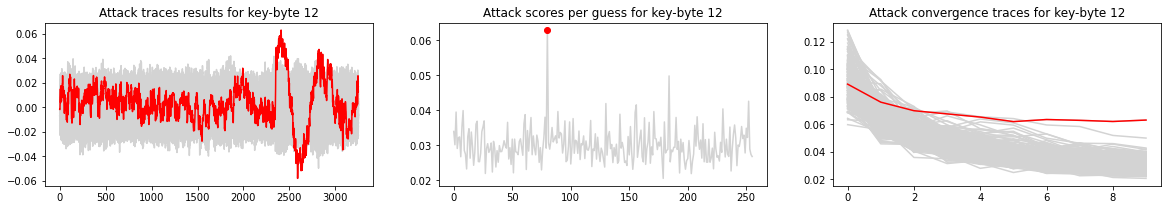

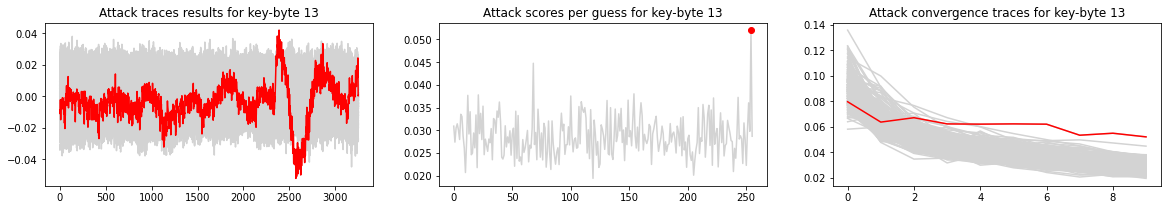

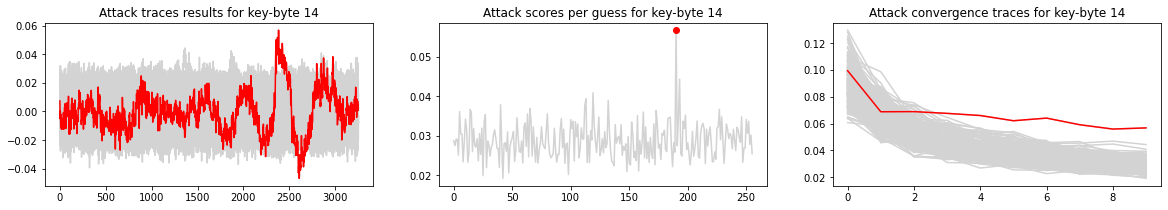

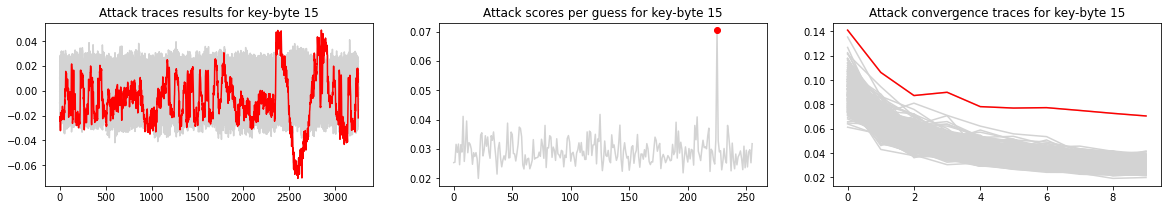

In [39]:
for key_byte in range(16):
    plt.rcParams['figure.figsize']=(20,3)
    
    plt.subplot(1,3,1)
    plt.title('Attack traces results for key-byte '+str(key_byte))
    for guess in range(256):
        plt.plot(attack_cpa_delta_last.results[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_cpa_delta_last.results[correct_key[key_byte],key_byte,:], color='red')

    plt.subplot(1,3,2)
    plt.title('Attack scores per guess for key-byte '+str(key_byte))
    plt.plot(attack_cpa_delta_last.scores[:,key_byte], color='Lightgrey')
    plt.plot(correct_key[key_byte], attack_cpa_delta_last.scores[correct_key[key_byte], key_byte], "o", color = 'red')

    
    plt.subplot(1,3,3)
    plt.title('Attack convergence traces for key-byte '+str(key_byte))
    for guess in range(256):
        plt.plot(attack_cpa_delta_last.convergence_traces[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_cpa_delta_last.convergence_traces[correct_key[key_byte],key_byte,:], color='red')

    plt.show()

-----
## Attack the last round in delta with ANOVA

In [41]:
attack_anova_delta_last = scared.ANOVAAttack(
        selection_function=scared.aes.selection_functions.encrypt.DeltaRLastRounds(),
        model=scared.HammingWeight(),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//10    
    )

In [42]:
attack_anova_delta_last.run(container)

In [44]:
found_key = attack_anova_delta_last.scores.argmax(0).squeeze()

In [45]:
vhex = np.vectorize(hex)
print("the last subkey round found is: ", vhex(found_key))

the last subkey round found is:  ['0x53' '0x9f' '0xb1' '0x88' '0x40' '0x7e' '0x2b' '0x3f' '0x2d' '0x5a'
 '0x24' '0x5f' '0x50' '0xfe' '0xbe' '0xe1']


In [46]:
found_key - correct_key

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Nous avons donc retrouvé les 16 bytes de la clef cette fois ci avec ANOVA.

#### Plot Results

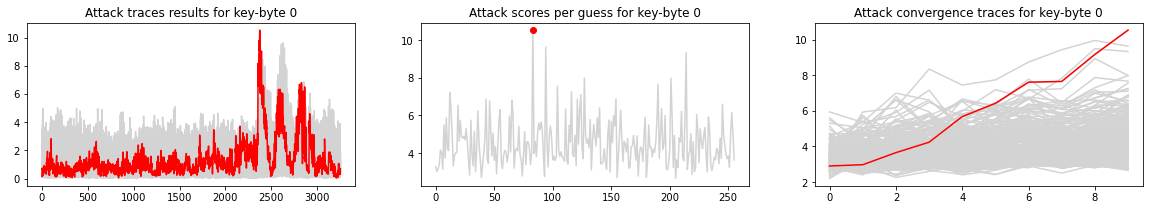

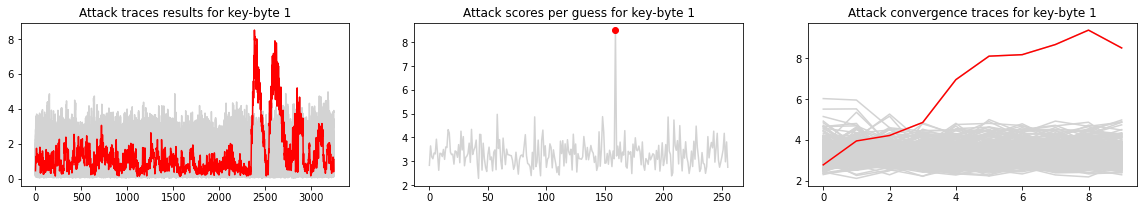

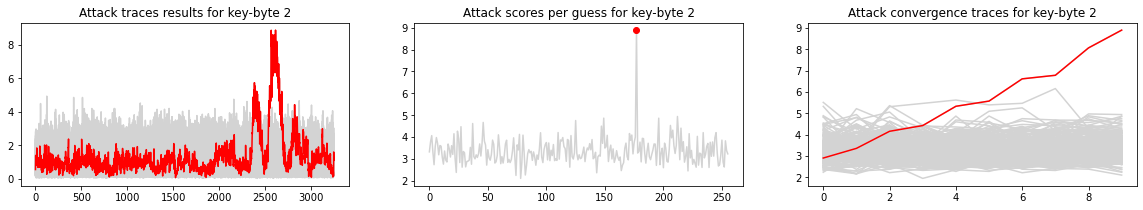

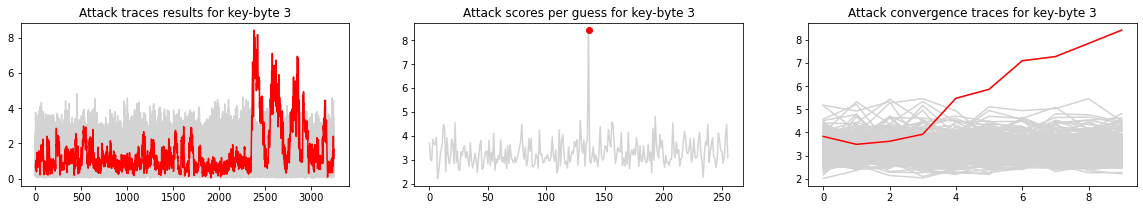

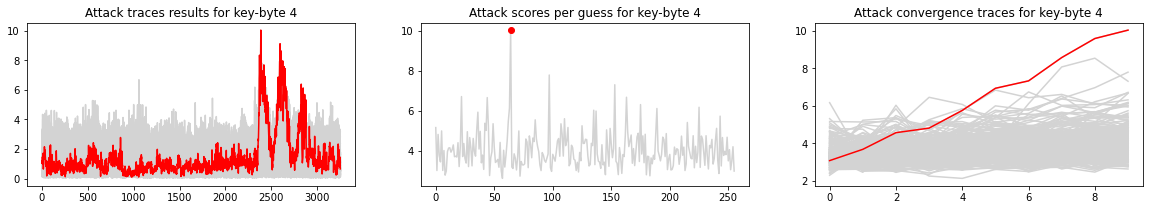

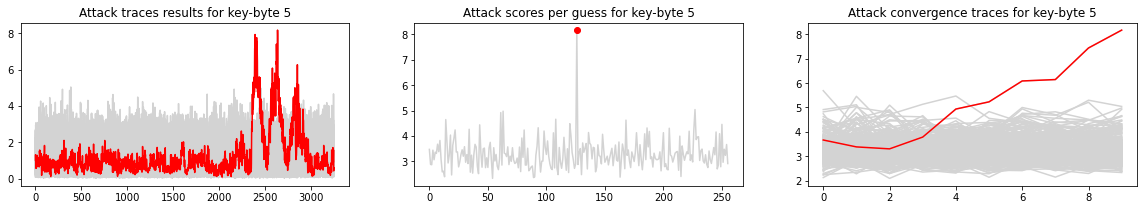

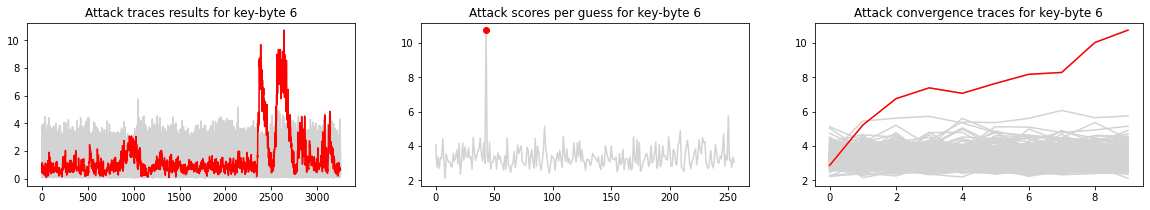

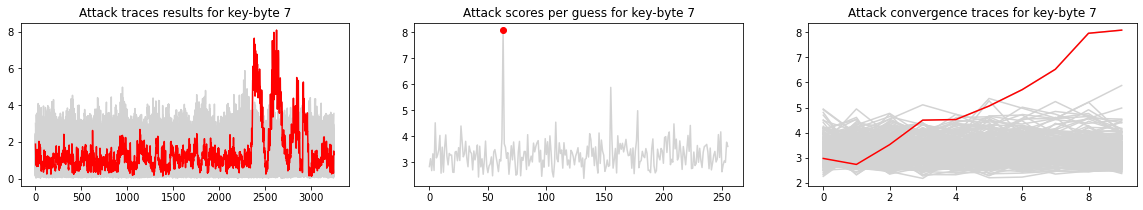

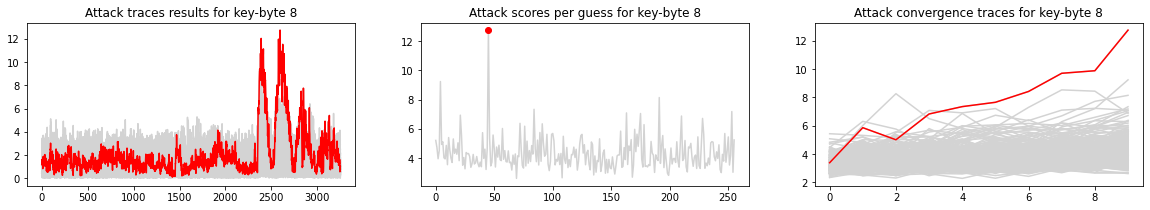

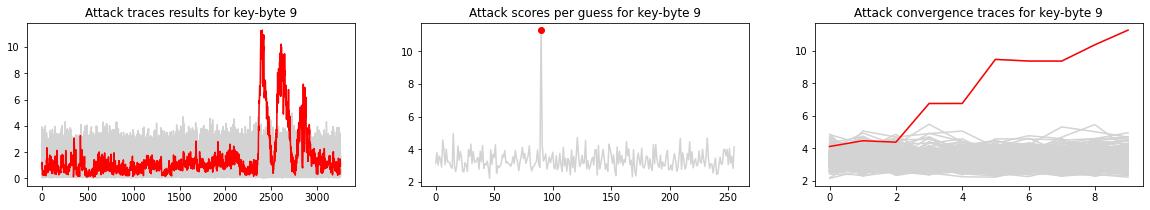

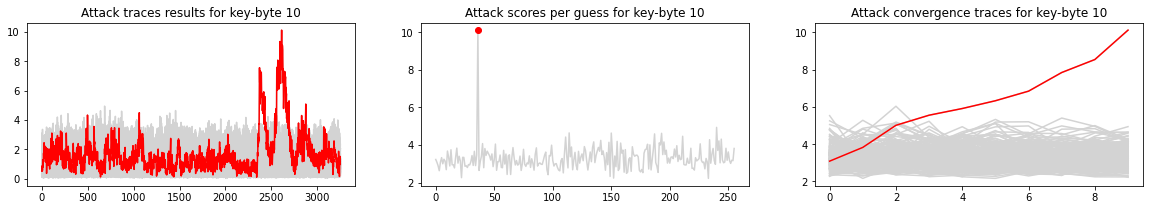

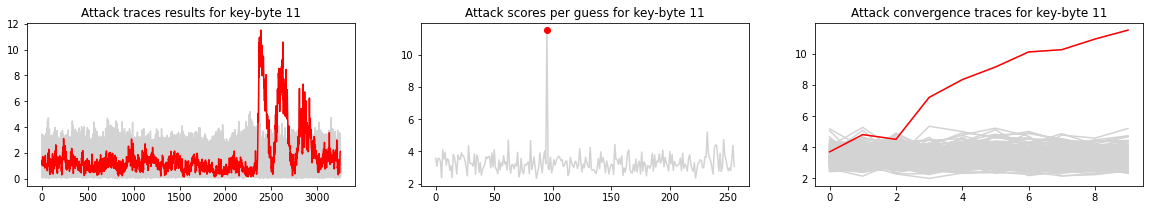

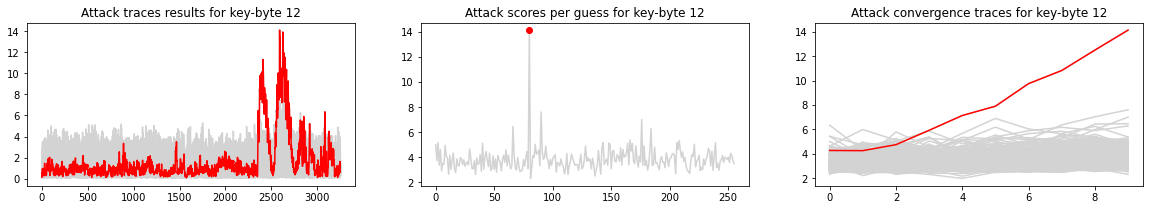

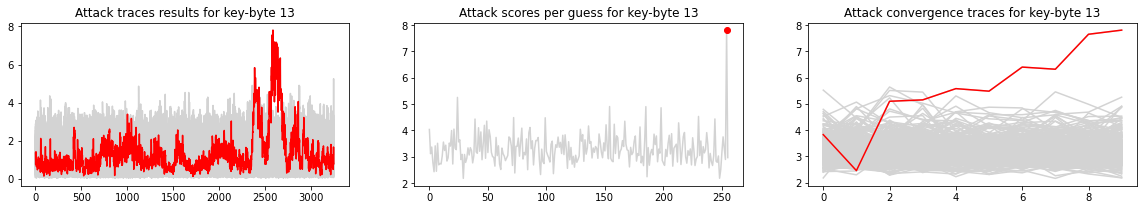

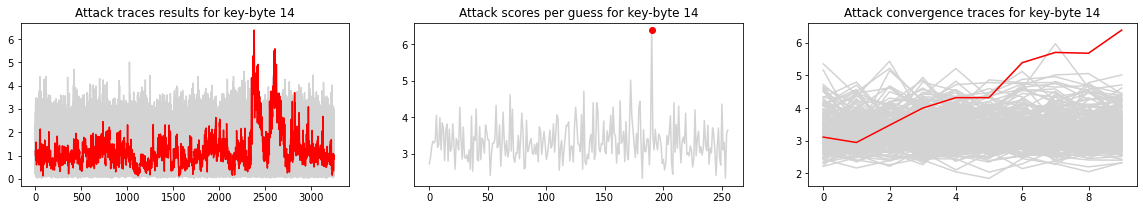

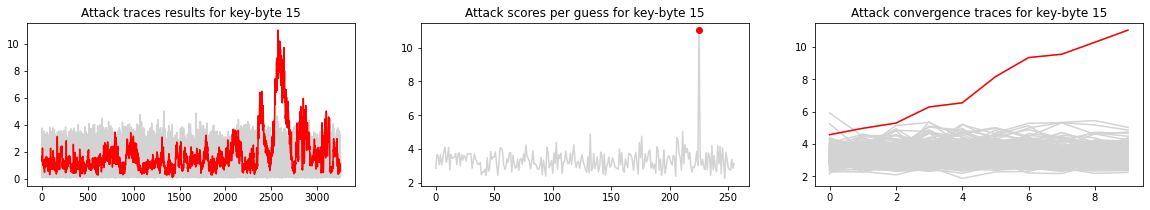

In [47]:
for key_byte in range(16):
    plt.rcParams['figure.figsize']=(20,3)
    
    plt.subplot(1,3,1)
    plt.title('Attack traces results for key-byte '+str(key_byte))
    for guess in range(256):
        plt.plot(attack_anova_delta_last.results[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_anova_delta_last.results[correct_key[key_byte],key_byte,:], color='red')

    plt.subplot(1,3,2)
    plt.title('Attack scores per guess for key-byte '+str(key_byte))
    plt.plot(attack_anova_delta_last.scores[:,key_byte], color='Lightgrey')
    plt.plot(correct_key[key_byte], attack_anova_delta_last.scores[correct_key[key_byte], key_byte], "o", color = 'red')

    
    plt.subplot(1,3,3)
    plt.title('Attack convergence traces for key-byte '+str(key_byte))
    for guess in range(256):
        plt.plot(attack_anova_delta_last.convergence_traces[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_anova_delta_last.convergence_traces[correct_key[key_byte],key_byte,:], color='red')

    plt.show()